# Exercise 3 - CNNs, ResNets and LR-Scheduling

 * Deep Learning for Computer Vision – Winter Term 2022/23
 * Organizers: Anwai Archit, Laura Hansel, Michaela Vystrcilova, Constantin Pape
 * Tutors: Anwai Archit, Mai Elshazly, Andreas Schneider, Fabio Seel, Shashwat Sridhar
 * Due date: **Monday, Dec 5, before 14:00**

### Time required to solve this exercise sheet
**As you will train a large number of models on this exercise sheet, model training will require an increased amount of time. So we recommend to start working on this sheet early.**

### Topics

In this exercise sheet, you will:
- work again with CIFAR-10
- implement a 1-layer CNN
- compare MLP and CNN
- vary architecture to improve model performance
- implement a ResNet for CIFAR-10
- learn about learning rate scheduling
- [learn about transfer learning]

*We are looking forward to seeing your solutions! Have fun!*

# IMPORTANT SUBMISSION INSTRUCTIONS

You should work on the exercises in groups of 2-3. It is on you how you collaborate, but please make sure that everyone contributes equally and also that you understand all the solutions.
You will be asked to present your group's solution in the tutorials and you should be well prepared to present any part of it.

- When you've completed the exercise, download the notebook and rename it to ```<surname1>_<surname2>_<surname3>.ipynb```.
- Only submit the Jupyter Notebook (ipynb file). No other file is required. Upload it on `Stud.IP` -> `Deep Learning for Computer Vision` -> `Files` -> `Submission of Homework 3`.
- Make only one submission of the exercise per group.
- The deadline is strict.
- In addition to the submissions, every member of your group should be prepared to present the exercise in the tutorials.

Implementation
- Do not change the cells which are marked as "DO NOT CHANGE", similarly write your solution to the marked cells.

### Imports

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, StepLR
import torchvision
from torchvision import datasets, transforms, models
import fastprogress
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import time

## 1. Setup

You can use the functions to grab the data, split the sets and create the dataloaders, etc. given to you at exercise sheet 2.

It is good practice to store functions that are constantly needed again in a separate file such that instead of copy-pasting the cells into each exercise notebook, you can use the python file containing the functions and import it in the notebooks.

If you work with Kaggle (which is recommended) you have to mount the drive first and create a path to your python module (or download the file from your drive).

#### **TODO**
Create a file named 'utils.py' and import it here. You can import any package necessary.

In [34]:
# TODO import utils.py
import utils

## 2. Load dataset, create dataloader, etc.

#### **TODO**
Call the functions of 'utils.py' to instantiate the train-, test- and validation datasets along with their dataloaders.

In [33]:
# TODO define device
device = utils.get_device()

cuda available: False ; cudnn available: True ; num devices: 0
Using device cpu


In [35]:
data_dir = 'data'
batch_size = 256

# TODO grab data, generate split, init data loaders
trainset, testset, dataset_mean, dataset_std = utils.grab_data(data_dir, num_cpus=1)
trainset, valset = utils.generate_train_val_data_split(trainset, split_seed=42, val_frac=0.2)
trainloader, valloader, testloader = utils.init_data_loaders(trainset, valset, testset, batch_size=batch_size, num_cpus=1)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


#### **TODO** 
Define the loss function. We use the cross entropy loss again.

In [5]:
# TODO define loss function
loss_function = nn.CrossEntropyLoss()

## 3. Simple 1-layer CNN model

### **TODO**
- Define the model.

The first step to training a model is defining its architecture. 
Define a sequential model with following structure:
*   Convolutional layer with 32 filters, kernel size of 5*5 and stride of 1.
*   Max Pooling layer with kernel size of 2*2 and default stride.
*   ReLU Activation Layers.
*   Linear layer with output of 512.
*   ReLU Activation Layers.
*   A linear layer with output of 10.

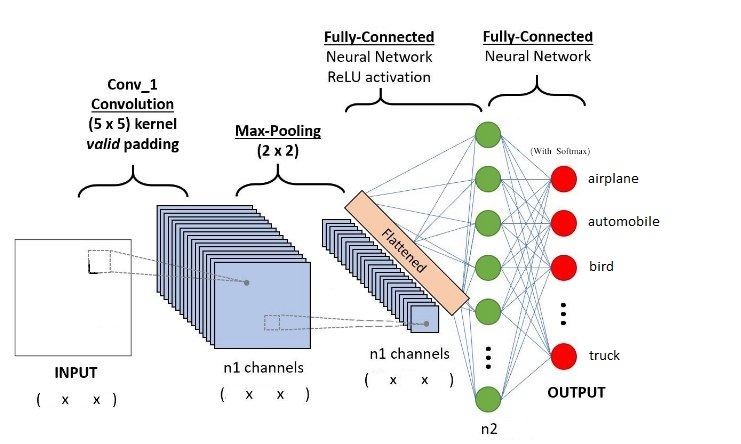

#### **Questions**

- What are the input dimensions?
- What are the dimensions of the feature maps?
- What are the dimensions after pooling?
- What is the value for n2 (in_features)?
- What is the number of parameters for conv_1?

In [ ]:
data = testloader.dataset.data
_, input_dim1, input_dim2, input_channels = data.shape
print('the input dimension is ', input_dim1, input_dim2, input_channels)

**Your answers here**

- The input dimensions are 3 channels with dimension 32x32

- 3 channels 32x32 
        -> Convolutional Layer: 32 layers 28x28 -> Max Pooling: 32 layers 14x14 -> flattening: 14x14x32 
        -> Linear layer 1: (14x14x32 -> n2 = 512) -> Output layer: (512 -> 10)
        
- Parameters after convolutional layer if there is no bias: 32x5x5x3

In [31]:
# TODO define model

class CNN(nn.Module):
    
    def __init__(self, input_dim, input_channels = 3, kernel_size1 = 5, stride1 = 1, num_classes = 10):
        
        super().__init__()
        
        self.input_dim = input_dim
        self.input_channels = input_channels
        self.kernel_size1 = kernel_size1
        self.stride1 = stride1
        self.num_classes = num_classes
        
        self.input_dim2 = int(((self.input_dim - self.kernel_size1)/self.stride1 + 1)/2)
        
        self.c1 = nn.Conv2d(in_channels = self.input_channels, out_channels = 32, kernel_size = 5, stride = 1)
        self.pool1 = nn.MaxPool2d(2,2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(self.input_dim2*self.input_dim2*32, 512)
        self.fc2 = nn.Linear(512, self.num_classes)
        
    def forward(self, x):

        x = self.c1(x)

        x = torch.flatten(self.relu(self.pool1(x)),1)
        
        x = self.relu(self.fc1(x))
        
        x = self.fc2(x)
        
        return x
   

#### **TODO**

- Train the model for 10 epochs. Use a learning rate of 0.001.
- Plot the results of accuracy and loss as you did in exercise sheet 2.

In [ ]:
# TODO train and plot
model0 = CNN(32, input_channels = 3, kernel_size1 = 5, stride1 = 1, num_classes = 10).to(device)

Epochs = 10
lr = 0.001

optimizer0 = optim.SGD(model0.parameters(), lr = lr)

train_losses0, val_losses0, train_accs0, val_accs0, confusion_matrix0 = utils.run_training(model0, optimizer0, loss_function, device, Epochs, trainloader, valloader, early_stopper=None, verbose=False)


In [ ]:
utils.plot('train vs validation loss', 'loss', train_losses0, val_losses0, yscale='linear', save_path=None, 
         extra_pt= True, extra_pt_label=np.argmin(val_losses0))
utils.plot('train vs validation accuracy', 'accuracy', train_accs0, val_accs0, yscale='linear', save_path=None, 
         extra_pt= True, extra_pt_label=np.argmin(val_losses0))   

#### **TODO**
Compare results to MLP. What can you observe?

**Your answers here**

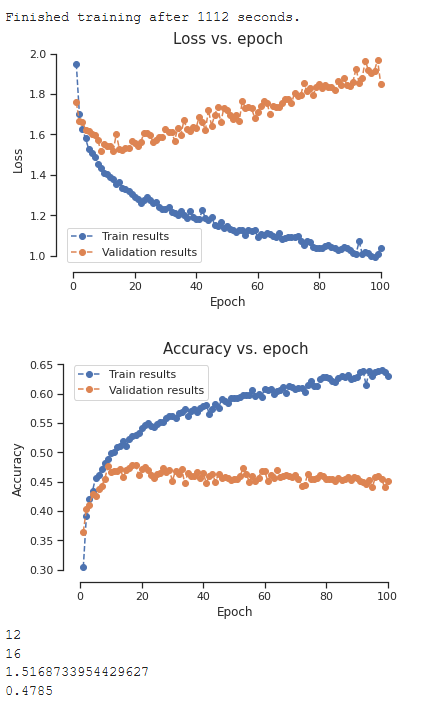

#### **TODO** 
Train longer (ca. 60 epochs), plot again.

In [ ]:
# TODO train and plot
#The model has already been saved
#Do not run this cell again!

torch.manual_seed(12)
model1 = CNN(32, input_channels = 3, kernel_size1 = 5, stride1 = 1, num_classes = 10).to(device)

Epochs = 60
lr = 0.001

optimizer1 = optim.SGD(model1.parameters(), lr = lr)

train_losses1, val_losses1, train_accs1, val_accs1, confusion_matrix1 = utils.run_training(model1, optimizer1, loss_function, device, Epochs, trainloader, valloader, early_stopper=None, verbose=False)


In [ ]:
torch.save(model1.state_dict(), 'model1.pt')

In [ ]:
model1_save = CNN(32, input_channels = 3, kernel_size1 = 5, stride1 = 1, num_classes = 10).to(device)
model1_save.load_state_dict(torch.load('model1.pt', map_location=device))

val_loss1_save, val_acc1_save, val_cm1_save = utils.validate(valloader, model1_save, loss_function, device, master_bar = None)

print(f'saved model validation accuracy: %.2f' %(100*val_acc1_save), '%')

In [36]:
import json

def save_list(list_name, my_list):
    with open(list_name, 'w') as f:
        json.dump(my_list, f, indent = 2)
        
def load_list(list_name):
    with open(list_name, 'r') as f:
        my_list = json.load(f)
    return my_list

In [ ]:
#save and load the lists, cause it takes a long time to run the code above!
#Do not run this cell again! 

save_list('train_losses1.json', train_losses1)
save_list('val_losses1.json', val_losses1)
save_list('train_accs1.json', train_accs1)
save_list('val_accs1.json', val_accs1)

In [ ]:
train_losses1_saved = load_list('train_losses1.json')
val_losses1_saved = load_list('val_losses1.json')
train_accs1_saved = load_list('train_accs1.json')
val_accs1_saved = load_list('val_accs1.json')

In [ ]:
print('validation loss minimum for best model 1 in epoch',np.argmin(val_losses1_saved) + 1, 'is ', np.min(val_losses1_saved))
print('validation accuracy maximum for best model 1 in epoch',np.argmax(val_accs1_saved) + 1, 'is %.2f' % (100*np.max(val_accs1_saved)),"%")

utils.plot('train vs validation loss', 'loss', train_losses1_saved, val_losses1_saved, yscale='linear', save_path=None, 
         extra_pt= True, extra_pt_label=np.argmin(val_losses1_saved))
utils.plot('train vs validation accuracy', 'accuracy', train_accs1_saved, val_accs1_saved, yscale='linear', save_path=None, 
         extra_pt= True, extra_pt_label=np.argmin(val_losses1_saved))   

#### **Questions**
- Why is that not an optimal model?
- What could be improved?

**Your answers here**

The accuracy is only around 50%. While this was okay in a normal fully connected layer, we expect more from a convolutional layer. This is due to the fact that when flattening the image in the previous exercise, we lose some information, whereas here, we keep the structure of the image, so the performace should be better. 

We need to add more layers to the model and go deeper. There could also be an issue with vanishing gradients so skipping connection could also potentially improve the performance.

## 4. CNN model with more convolutional layers

#### **TODO**
Define the architecture displayed in the graphic.

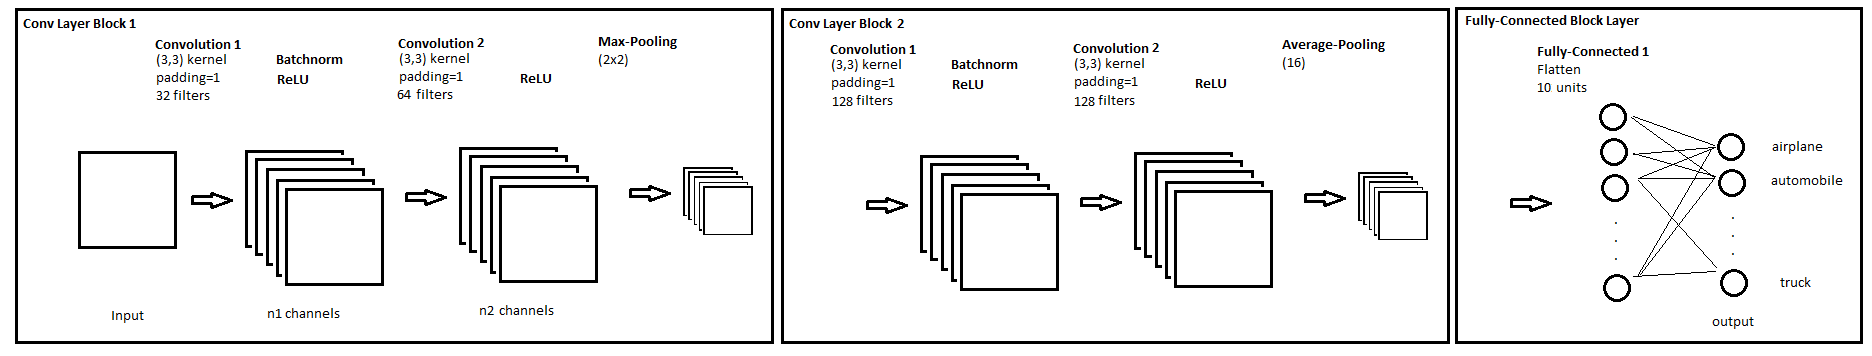

#### **Questions**

- Padding is used in the convolutional layers. What does that mean, which variants exist and how does it influence the dimensions of the feature maps?
- What does padding=1 mean in the case of the network displayed above?
- What are the dimensions of the feature maps after the 1. conv layer?
- What are the dimensions of the feature maps after the 2. conv layer?
- What ist the receptive field size after the first two convolutions?
- What is the value for the in_features for the fully-connected layer?
- What is the number of parameters of *Conv Layer block 1*?

**Your answers here**

- Padding is used to add pixels with value 0 to each side of the output of a convolutional layer. The variants are either "valid" or "same". In valid padding nothing is added and in "same" padding one adds as many pixles as necessary to the output so the dimension of the output is the same as the input.

- Padding = 1 indicates that you add 1 pixel to each side of the output.

- Say the input image is $N_0 \times N_0$ (in this particular case $N = 32$), no stride is given, so we shall say $s = 1$ and the kernel is $k \times k = 3 \times 3$ and so 

$N_1 = N_0 - k + 1 + 2p = N_0 - 3 +1 + 2 = N_0$

so the dimension of the output is the same after the 1. convolutional layer, only with 32 filters.

$32 \times (N_0 \times N_0)$

- This is the same as with the first convolutional layer, just with different number of filters:

$64 \times (N_0 \times N_0)$

- Padding has no effect on the RF, only stride and kernel size:

$RF1 = \sum_{l = 1}^{L} \bigg((k_l - 1) \prod_{i = 1}^{l -1} s_i\bigg) + 1 = (3 - 1) + (3 - 1) + 1 =  5$

- $1 \times 1 \times 128$

- Assuming that there are no biases:

$32 \times 3 \times 3 \times 1 + 64 \times 3 \times 3 \times 32$

In [ ]:
#TODO define model 2


class CNN2(nn.Module):
    
    def __init__(self, input_dim, input_channels = 3, kernel_size = 3, stride = 1, num_classes = 10):
        
        super().__init__()
        
        self.input_dim = input_dim
        self.input_channels = input_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.num_classes = num_classes
        
        #self.input_dim2 = int(((self.input_dim - self.kernel_size)/self.stride + 1)/2)
        
        #Block 1:
        self.c1 = nn.Conv2d(in_channels = self.input_channels, out_channels = 32, kernel_size = self.kernel_size, stride = 1, padding = 1)
        self.norm1 = nn.BatchNorm2d(num_features = 32)
        self.c2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = self.kernel_size, stride = 1, padding = 1)
        self.pool1 = nn.MaxPool2d(2,2)
        self.relu = nn.ReLU()
        
        #Block 2:
        self.c3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = self.kernel_size, stride = 1, padding = 1)
        self.norm2 = nn.BatchNorm2d(num_features = 128)
        self.c4 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = self.kernel_size, stride = 1, padding = 1)
        self.pool2 = nn.AvgPool2d(kernel_size = 16)
        
        #Fully connected block
        self.fc1 = nn.Linear(128, 10)
        
        
    def forward(self, x):
        
        #block 1

        x = self.relu(self.norm1(self.c1(x)))
        
        x = self.pool1(self.relu(self.c2(x)))
        
          
        #block2
        
        x = self.relu(self.norm2(self.c3(x)))
        
        x = self.pool2(self.relu(self.c4(x)))
        
        
        #block 3

        x = self.fc1(torch.flatten(x,1))

        
        return x
   

#### **TODO** 

- train the new net (30 epochs, lr=0.1), plot the results, and compare the results to the 1-layer CNN
- explain why you observe these results

In [ ]:
# TODO train and plot
#The model has already been saved
#Do not run this cell again!!!!!!!!!!!!!!!

torch.manual_seed(12)
model2 = CNN2(32, input_channels = 3, kernel_size = 3, stride = 1, num_classes = 10).to(device)

Epochs = 30
lr = 0.1

optimizer2 = optim.SGD(model2.parameters(), lr = lr)

train_losses2, val_losses2, train_accs2, val_accs2, confusion_matrix2 = utils.run_training(model2, optimizer2, loss_function, device, Epochs, trainloader, valloader, early_stopper=None, verbose=False)


In [ ]:
torch.save(model2.state_dict(), 'model2.pt')

In [ ]:
model2_save = CNN2(32, input_channels = 3, kernel_size = 3, stride = 1, num_classes = 10).to(device)
model2_save.load_state_dict(torch.load('model2.pt', map_location=device))

val_loss2_save, val_acc2_save, val_cm2_save = utils.validate(valloader, model2_save, loss_function, device, master_bar = None)

print(f'saved model validation accuracy: %.2f' %(100*val_acc2_save), '%')

In [ ]:
#save and load the lists, cause it takes a long time to run the code above!
#Do not run this cell again! 
        
save_list('train_losses2.json', train_losses2)
save_list('val_losses2.json', val_losses2)
save_list('train_accs2.json', train_accs2)
save_list('val_accs2.json', val_accs2)

In [25]:
train_losses2_saved = load_list('train_losses2.json')
val_losses2_saved = load_list('val_losses2.json')
train_accs2_saved = load_list('train_accs2.json')
val_accs2_saved = load_list('val_accs2.json')

validation loss minimum for best model 2 in epoch 30 is  0.874051034450531
validation accuracy maximum for best model 2 in epoch 30 is 70.75 %


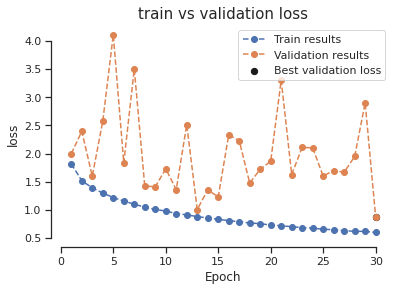

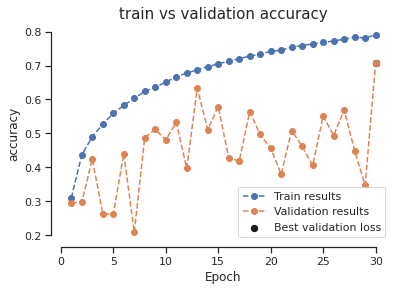

In [26]:
print('validation loss minimum for best model 2 in epoch',np.argmin(val_losses2_saved) + 1, 'is ', np.min(val_losses2_saved))
print('validation accuracy maximum for best model 2 in epoch',np.argmax(val_accs2_saved) + 1, 'is %.2f' % (100*np.max(val_accs2_saved)),"%")

utils.plot('train vs validation loss', 'loss', train_losses2_saved, val_losses2_saved, yscale='linear', save_path=None, 
         extra_pt= True, extra_pt_label=np.argmin(val_losses2_saved))
utils.plot('train vs validation accuracy', 'accuracy', train_accs2_saved, val_accs2_saved, yscale='linear', save_path=None, 
         extra_pt= True, extra_pt_label=np.argmin(val_losses2_saved))   

## 5. ResNet architecture

"*Deeper neural networks are more difficult to train.  We present a residual learning framework to ease the training of networks that are substantially deeper than those used previously.*" [ https://arxiv.org/pdf/1512.03385.pdf]

That was the intention of He et al. to develop residual networks.

A ResNet is built of blocks which are called the *Residual Blocks*. 
A residual block uses *skip connections* - shortCuts — to jump over some layers to skip some activations.
The Resnet skips connections via addition.

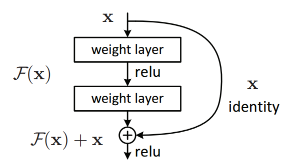

#### **Questions**
- Which problems do using skip connections solve?
- Why is a residual network called residual? 
- When is the advantage of ResNets over 'normal' CNNs most visible?

**Your answers here**

1 - Mostly solve the problems of optimizing deep neural networks. The deeper the network goes, the more accuracy degrades, and the less "important" the earlier layers are, seeing as they change very little through backpropagation.

2 - It is called that because in these residual blocks, instead of the network learning the usual feature mapping like in plain networks, it would learn the residual instead and add the identity function to it. This way, even if the residual was 0, the network would just learn the identity mapping.

3 - It is most visible when we up the number of layers by a significant amount, seeing as that's when the performance of plain networks decreases

#### **TODO**
- write a class **ResidualBlock(nn.Module)** where you define the blocks used in the ResNet
- write a class **ResNet(nn.Module)** where you define the model
- train the model
- plot results

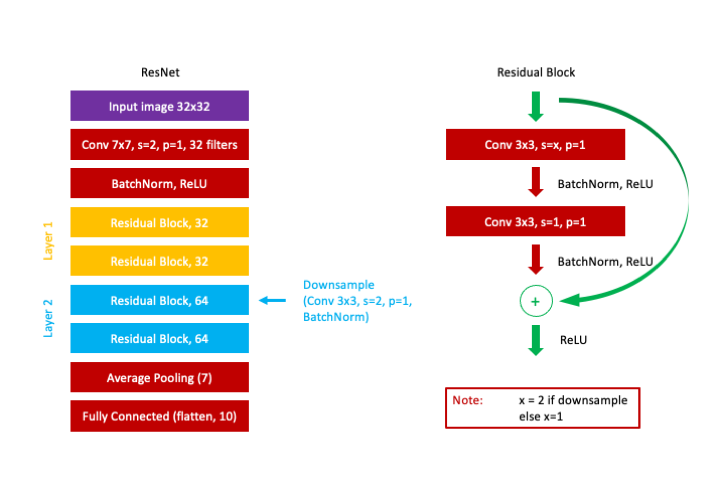

**Hints**

- The downsampling in this ResNet happens between layer 1 and layer 2. In this step, the channel size is increased (32 -> 64) and the image resolution is downsampled by strided convolution (stride=2 in the Conv2d layers).
- For the adding part, the dimensions obviously have to be the same. This is accomplished by using stride=2 in the first Conv2d layer of the block while the second layer does not change the dimensions.
- The average-pooling layer has kernel size 7.
- For you to ensure everything works fine, here are the shapes in the form [(batchsize), x, y, channel] where I discard batchsize, because it does not change.
32x32x3 -> conv 7x7 -> 14x14x32 -> layer 1 -> 14x14x32 -> layer2 -> 7x7x64 -> avpool(7) -> 1x1x64 -> linear(64, 10)

In [30]:
# TODO write a class ResidualBlock(nn.Module) where you define the blocks used in the ResNet
class ResidualBlock(nn.Module):

  def __init__(self, input_channels, out_channels, downsample=False):

    super().__init__()

    self.input_channels = input_channels
    self.output_channels = out_channels
    self.downsample = downsample
    self.stride = 1
    self.intermediate_channels = self.input_channels
    self.relu = nn.ReLU()

    if self.downsample:
      self.stride = 2
      self.intermediate_channels = 64

    self.c1 = nn.Conv2d(in_channels = self.input_channels, out_channels=self.intermediate_channels, stride=self.stride, kernel_size=3, padding=1)
    self.norm1 = nn.BatchNorm2d(num_features=self.output_channels)

    self.c2 = nn.Conv2d(in_channels = self.intermediate_channels, out_channels=self.output_channels, stride=1, kernel_size=3, padding=1)
    self.norm2 = nn.BatchNorm2d(num_features=self.output_channels)

  def forward(self, x):
    identity = x

    if self.downsample:
      self.lin_projection = nn.Conv2d(in_channels = self.input_channels, out_channels=self.output_channels, stride=self.stride, kernel_size=1)
      identity = self.lin_projection(identity)

    # Block 1
    x = self.c1(x)
    x = self.norm1(x)
    x = self.relu(x)

    # Block 2

    x = self.c2(x)
    x = self.norm2(x)
    x = self.relu(x)

    # print("x shape: ", x.shape)
    # print("identity shape: ", identity.shape)

    x = x + identity
    x = self.relu(x)
    return x


In [38]:
# TODO write a class ResNet(nn.Module) where you define the model

class ResNet(nn.Module):

  def __init__(self):

    super().__init__()
    self.relu = nn.ReLU()

    ##### Red Layer
    self.c1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size = 7, stride=2, padding=1)
    self.norm1 = nn.BatchNorm2d(num_features = 32)

    ##### Layer 1 (Yellow)
    self.rb11 = ResidualBlock(32, 32, False)
    self.rb12 = ResidualBlock(32, 32, False)

    ##### Layer 2 (Blue)
    self.rb21 = ResidualBlock(32, 64, True)
    self.rb22 = ResidualBlock(64, 64, False)

    ##### 2nd Red Layer
    self.avgPool = nn.AvgPool2d(kernel_size = 7)
    self.fc1 = nn.Linear(64, 10)

  def forward(self, x):
    
    ##### Red Layer
    # print("-----block 1-----")
    x = self.relu(self.norm1(self.c1(x)))

    ##### Layer 1
    # print("-----Yellow block-----")
    x = self.rb11(x)
    x = self.rb12(x)

    ##### Layer 2
    # print("-----blue block-----")
    x = self.rb21(x)
    x = self.rb22(x)

    ##### 2nd Red Layer
    # print("-----last block-----")
    x = self.avgPool(x)
    x = self.fc1(torch.flatten(x,1))

    return x
    






In [39]:
resnet2 = ResNet()

In [40]:
# TODO train ResNet, using the architecture laid out in the comments and figures above


Epochs = 30
lr = 0.01

optimizer_resnet = optim.SGD(resnet2.parameters(), lr = lr)

train_losses_resnet, val_losses_resnet, train_accs_resnet, val_accs_resnet, confusion_matrix_resnet = utils.run_training(resnet2, optimizer_resnet, loss_function, device, Epochs, trainloader, valloader, early_stopper=None, verbose=True)


Finished training after 3410 seconds.


In [50]:
# Cell saves the model, saves json lists of the accuracies and losses
# Unclear: why i need to specify strict=False or otherwise get an Error(s) in loading state_dict for ResNet: Unexpected key(s) in state_dict: "rb21.lin_projection.weight", "rb21.lin_projection.bias".
# Guess: something to do with downsampling, since it only happens in resnet block rb21
torch.save(resnet2.state_dict(), 'resnet_model.pt')

model_resnet_save = ResNet().to(device)
model_resnet_save.load_state_dict(torch.load('resnet_model.pt'), strict=False)

val_loss_resnet_save, val_acc_resnet_save, val_cm_resnet_save = utils.validate(valloader, model_resnet_save, loss_function, device, master_bar = None)

print(f'saved model validation accuracy: %.2f' %(100*val_acc_resnet_save), '%')



saved model validation accuracy: 31.05 %


In [45]:
# Cell saves the json lists of the accuracies and losses
save_list('train_losses_resnet2.json', train_losses_resnet)
save_list('val_losses_resnet2.json', val_losses_resnet)
save_list('train_accs_resnet2.json', train_accs_resnet)
save_list('val_accs_resnet2.json', val_accs_resnet)

In [48]:
# Cell to load the saved losses and accuracies
train_losses_resnet_saved2 = load_list('train_losses_resnet2.json')
val_losses_resnet_saved2 = load_list('val_losses_resnet2.json')
train_accs_resnet_saved2 = load_list('train_accs_resnet2.json')
val_accs_resnet_saved2 = load_list('val_accs_resnet2.json')

validation loss minimum for resnet is in epoch 29 is: 1.3374876618385314
validation accuracy maximum for resnet is in epoch 29 is 54.74 %


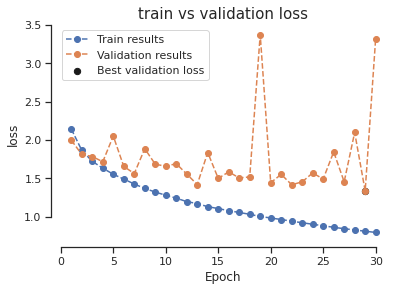

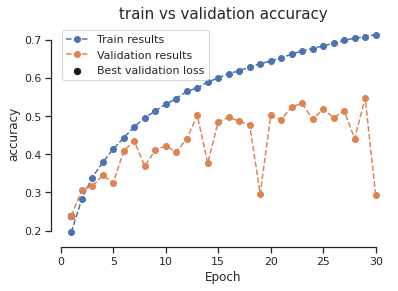

In [49]:
# TODO plot loss and accuracy for training and validation set

print('validation loss minimum for resnet is in epoch',np.argmin(val_losses_resnet_saved2) + 1, 'is:', np.min(val_losses_resnet_saved2))
print('validation accuracy maximum for resnet is in epoch',np.argmax(val_accs_resnet_saved2) + 1, 'is %.2f' % (100*np.max(val_accs_resnet_saved2)),"%")

utils.plot('train vs validation loss', 'loss', train_losses_resnet_saved2, val_losses_resnet_saved2, yscale='linear', save_path=None, 
         extra_pt= True, extra_pt_label=np.argmin(val_losses_resnet_saved2))
utils.plot('train vs validation accuracy', 'accuracy', train_accs_resnet_saved2, val_accs_resnet_saved2, yscale='linear', save_path=None, 
         extra_pt= True, extra_pt_label=np.argmin(val_accs_resnet_saved2))   

#### **Questions**
- Does the performance increase compared to the CNNs you trained before? Why/Why not?
- Compare the runtime of CNN and ResNet.

**Your answers here**

1 - With a learning rate of 0.1, the performance is actually worse than the CNN. We can see that the one thing that they have in common is that the validation accuracy and loss fluctuate a lot.

2 - They have rougly the same runtime (~1 hour)

## 6. Explore Learning Rate Scheduling

Learning rate scheduling is a mechanism to adjust the learning rate.

*torch.optim.lr_scheduler* provides several methods based on the number of epochs. Learning rate scheduling should be applied after optimizer’s update.

#### **TODO**
- change run_training and extend to use scheduler for learning rate
- use StepLR (https://pytorch.org/docs/stable/optim.html), use the ResNet, train for 10 epochs. Start with a learning rate of 0.1.


#### **Questions**

- Try step size 1, gamma 0.1
    - How does it change the learning rate?
    - what do you observe regarding performance?
- Try step size 1, gamma 0.9, what do you observe?
    - How does it change the learning rate?
    - what do you observe regarding performance?
- What can you conclude of this experiment regarding the synergy of step size and gamma to get a good schedule?

**Your answers here**

In [27]:
# TODO change run_training (you can copy the code from utils.py here and create a new method here 
# or just change/create a new method it in the python file)

In [ ]:
# TODO train and plot with step size 1, gamma 0.1

In [ ]:
# TODO train and plot with step size 1, gamma 0.9

#### **TODO** 

Use step size 15, gamma 0.1. Train for 30 epochs.

#### **Questions**
- Does it improve performance?
- What can you observe in the plots?

**Your answers here**

In [ ]:
# TODO train and plot with step size 15, gamma 0.1, 30 epochs.

## [7. Optional LR-Scheduling]

#### **TODO**
- try two more scheduler: ExponentialLR and ReduceLROnPlateau 
- vary the parameters, which work best?
- does it improve performance compared to no scheduler?
- does it improve performance compared to StepLR?

**Your answers here**

In [ ]:
# TODO train and plot

## [8. Optional Transfer Learning]

### **TODO**

- load a pretrained ResNet from torchvision
- freeze the parameters so that the gradients are not computed
- replace the last fully-connected layer
- fine-tune the model
- plot the results again and compare to approaches before
    - is a better performance reached? why/why not?
    - does it take more/less time to fine-tune compared to train a resnet?

**Your answers here**

In [ ]:
# TODO do transfer learning with resnet on cifar10